# Install Necessary Packages

In [1]:
# Step 0: Install Necessary Packages
!pip install -q gradio                  # Install Gradio for creating web UI
!pip install -q yt-dlp                  # Install yt-dlp for downloading YouTube videos
!pip install -q openai whisper          # Install OpenAI API client and Whisper for speech recognition
!pip install -q youtube-transcript-api  # Install package to fetch YouTube captions (as backup)
!pip install -q langchain langchain-community langchain-openai  # Install LangChain ecosystem libraries
!pip install -q sentence-transformers   # Install sentence transformers for embedding generation
!pip install -q chromadb                # Install ChromaDB for vector storage
!pip install -q pydub                   # Install pydub for audio file processing
!pip install -q langsmith               # Install LangSmith for testing, evaluation, deployment
!pip install -q git+https://github.com/openai/whisper.git  # Install latest Whisper version from GitHub
!pip install -q tqdm                    # Install tqdm for progress bars


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.3/173.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

# Setup Environment and Import Libraries

In [2]:
# Step 1: Setup Environment and Import Libraries
import os  # Provides OS-level functionalities
import time  # For tracking execution time
import textwrap  # For wrapping text nicely
import tempfile  # For creating temporary directories/files
from pathlib import Path  # Easier file path handling
from typing import List, Dict, Any, Optional  # Type hints
from tqdm.auto import tqdm  # Progress bar for loops

# Audio/Video Processing
import yt_dlp  # To download YouTube videos
import whisper  # OpenAI Whisper model for transcription
from pydub import AudioSegment  # For handling audio files
from youtube_transcript_api import YouTubeTranscriptApi  # Backup method for fetching YouTube captions

# UI and Interface
import gradio as gr  # Gradio for building interactive web apps

# Vector Store and Embeddings
import chromadb  # Chroma database for storing vectors
from sentence_transformers import SentenceTransformer  # Local embedding model for text embeddings

# LangChain Components
from langchain.text_splitter import RecursiveCharacterTextSplitter  # To split large text into manageable chunks
from langchain_openai import OpenAIEmbeddings, ChatOpenAI  # OpenAI interfaces for embeddings and chat models
from langchain_community.vectorstores import Chroma  # Chroma wrapper inside LangChain
from langchain.chains import RetrievalQA  # Chain for retrieval-based question answering
from langchain.prompts import PromptTemplate  # Custom prompt templates
from langsmith import Client  # Client for LangSmith testing/tracing

# Mount Google Drive if in Colab
try:
    from google.colab import drive, userdata  # Import Google Colab specific modules
    IN_COLAB = True  # Flag indicating Colab environment
    drive.mount('/content/drive')  # Mount Google Drive to access secrets or files

    # Set API keys from Colab userdata
    os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable LangChain tracing
    os.environ["LANGCHAIN_API_KEY"] = userdata.get("LANGCHAIN_API_KEY")  # Set LangChain API key
    os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")  # Set OpenAI API key

    # Confirm API keys are set
    print("LANGCHAIN_API_KEY is set:", os.environ.get("LANGCHAIN_API_KEY") is not None)
    print("OPENAI_API_KEY is set:", os.environ.get("OPENAI_API_KEY") is not None)
except ImportError:
    IN_COLAB = False  # Not running in Colab
    # Warn user to manually set API keys
    print("Not running in Google Colab - make sure API keys are set")


Mounted at /content/drive
LANGCHAIN_API_KEY is set: True
OPENAI_API_KEY is set: True


# Define YouTube Video Downloader

In [3]:
# Step 2: Define YouTube Video Downloader
class YouTubeProcessor:
    def __init__(self, output_dir: str = "./downloads"):
        """Initialize with an output directory for downloaded files."""
        self.output_dir = output_dir  # Store output directory path
        Path(output_dir).mkdir(exist_ok=True)  # Create output directory if it doesn't exist

        # yt-dlp configuration
        self.ydl_opts = {
            'format': 'bestaudio/best',  # Download best available audio format
            'outtmpl': f'{output_dir}/audio_%(id)s.%(ext)s',  # Output filename template
            'postprocessors': [{
                'key': 'FFmpegExtractAudio',  # Extract audio using FFmpeg
                'preferredcodec': 'mp3',  # Convert audio to mp3
                'preferredquality': '192',  # Set quality to 192kbps
            }],
            'quiet': True  # Suppress detailed output
        }

    def extract_video_id(self, url: str) -> str:
        """Extract YouTube video ID from URL."""
        if "youtu.be" in url:  # Short URL format
            video_id = url.split("/")[-1].split("?")[0]  # Extract ID
        elif "youtube.com" in url:  # Standard YouTube URL
            video_id = url.split("v=")[1].split("&")[0]  # Extract ID
        else:
            raise ValueError(f"Invalid YouTube URL: {url}")  # Raise error if URL format is wrong
        return video_id

    def download_videos(self, video_urls: List[str]) -> List[str]:
        """Download audio from YouTube videos and return file paths."""
        downloaded_files = []  # Initialize empty list for downloaded file paths

        print(f"Downloading {len(video_urls)} videos...")  # Inform how many videos to download
        with yt_dlp.YoutubeDL(self.ydl_opts) as ydl:  # Initialize yt-dlp with options
            for url in tqdm(video_urls, desc="Downloading"):  # Show progress bar
                video_id = self.extract_video_id(url)  # Get video ID
                file_path = f"{self.output_dir}/audio_{video_id}.mp3"  # Expected file path

                # Skip if already downloaded
                if Path(file_path).exists():
                    print(f"File already exists: {file_path}")  # Inform if already downloaded
                    downloaded_files.append(file_path)
                    continue

                try:
                    ydl.download([url])  # Download the audio
                    downloaded_files.append(file_path)  # Add to list
                except Exception as e:
                    print(f"Error downloading {url}: {e}")  # Print error if download fails

                    # Try to get captions as fallback
                    try:
                        transcript = YouTubeTranscriptApi.get_transcript(video_id)  # Attempt to fetch transcript
                        transcript_text = " ".join([entry["text"] for entry in transcript])  # Combine transcript lines
                        text_file = f"{self.output_dir}/transcript_{video_id}.txt"  # Save as text file
                        with open(text_file, "w", encoding="utf-8") as f:
                            f.write(transcript_text)
                        print(f"Retrieved transcript instead: {text_file}")  # Inform user
                    except Exception as e2:
                        print(f"Failed to get transcript too: {e2}")  # Print second error if both fail

        return downloaded_files  # Return list of successfully downloaded files


# Audio Transcription with Whisper

In [4]:
# Step 3: Audio Transcription with Whisper
class TranscriptionProcessor:
    def __init__(self, model_size: str = "base"):
        """Initialize with specified Whisper model size."""
        print(f"Loading Whisper model ({model_size})...")  # Log model loading
        self.model = whisper.load_model(model_size)  # Load Whisper model
        print("Whisper model loaded")  # Confirm model is ready

    def transcribe_audio(self, audio_files: List[str]) -> Dict[str, str]:
        """Transcribe audio files and return dict of {file_path: transcript}."""
        transcripts = {}  # Initialize transcripts dictionary

        for audio_file in tqdm(audio_files, desc="Transcribing"):  # Loop with progress bar
            text_filename = audio_file.replace(".mp3", ".txt")  # Expected transcript file path

            # Skip if transcript already exists
            if Path(text_filename).exists():
                with open(text_filename, "r", encoding="utf-8") as f:
                    transcripts[audio_file] = f.read()  # Load existing transcript
                print(f"Using existing transcript: {text_filename}")  # Inform user
                continue

            try:
                result = self.model.transcribe(audio_file)  # Transcribe audio
                with open(text_filename, "w", encoding="utf-8") as f:
                    f.write(result['text'])  # Save transcription to file
                transcripts[audio_file] = result['text']  # Add to dictionary
                print(f"Transcribed {audio_file} → {text_filename}")  # Inform success
            except Exception as e:
                print(f"Error transcribing {audio_file}: {e}")  # Handle transcription error

        return transcripts  # Return dict of transcripts


# Vector Database Management

In [5]:
# Step 4: Vector Database Management
class VectorDatabaseManager:
    def __init__(
        self,
        persist_directory: str = "./chroma_store",
        collection_name: str = "youtube_transcripts",
        chunk_size: int = 500,
        chunk_overlap: int = 50
    ):
        """Initialize the vector database manager."""
        self.persist_directory = persist_directory  # Where to save Chroma DB
        self.collection_name = collection_name  # Collection name in Chroma
        self.chunk_size = chunk_size  # Chunk size for text splitting
        self.chunk_overlap = chunk_overlap  # Overlap between text chunks

        Path(persist_directory).mkdir(exist_ok=True)  # Create persistence directory if needed

        self.local_embed_model = SentenceTransformer('all-MiniLM-L6-v2')  # Local embedding model for fallback

        try:
            self.openai_embed_model = OpenAIEmbeddings()  # Try to load OpenAI embeddings
            self.use_openai_embeddings = True  # Use OpenAI if available
            print("Using OpenAI embeddings")  # Inform user
        except Exception:
            self.use_openai_embeddings = False  # Otherwise fallback
            print("Falling back to local embeddings")  # Inform fallback

        self.client = chromadb.PersistentClient(path=persist_directory)  # Initialize Chroma client
        self.collection = self.client.get_or_create_collection(name=collection_name)  # Create/Get collection

        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=chunk_size,
            chunk_overlap=chunk_overlap,
            length_function=len
        )  # Create a text splitter

    def store_transcripts(self, transcripts: Dict[str, str]) -> None:
        """Store transcript texts in vector database."""
        if not transcripts:
            print("No transcripts to store")  # Exit if nothing to store
            return

        all_chunks = []  # Store all text chunks
        all_metadatas = []  # Store corresponding metadata

        for file_path, text in transcripts.items():  # Iterate transcripts
            source_id = Path(file_path).stem  # Unique ID per file

            chunks = self.text_splitter.split_text(text)  # Split transcript into chunks
            metadatas = [{"source": source_id, "chunk_id": i} for i in range(len(chunks))]  # Metadata per chunk

            all_chunks.extend(chunks)  # Add to chunk list
            all_metadatas.extend(metadatas)  # Add to metadata list

        # Generate and store embeddings
        if self.use_openai_embeddings:
            vectordb = Chroma(  # Use LangChain's Chroma wrapper
                persist_directory=self.persist_directory,
                embedding_function=self.openai_embed_model,
                collection_name=self.collection_name
            )
            vectordb.add_texts(texts=all_chunks, metadatas=all_metadatas)  # Add texts
            vectordb.persist()  # Save changes
        else:
            embeddings = self.local_embed_model.encode(all_chunks).tolist()  # Local embeddings

            ids = [f"chunk_{i}" for i in range(len(all_chunks))]  # IDs for each chunk
            self.collection.add(
                documents=all_chunks,
                embeddings=embeddings,
                metadatas=all_metadatas,
                ids=ids
            )

        print(f"Stored {len(all_chunks)} chunks in Chroma vector database")  # Confirm completion

    def get_retriever(self, top_k: int = 5):
        """Get a retriever for the vector database."""
        if self.use_openai_embeddings:
            vectordb = Chroma(
                persist_directory=self.persist_directory,
                embedding_function=self.openai_embed_model,
                collection_name=self.collection_name
            )
            return vectordb.as_retriever(search_kwargs={"k": top_k})  # Return retriever
        else:
            return None  # No retriever if local embeddings used (needs extra code)


# Question Answering Chain

In [6]:
# Step 5: Question Answering Chain
class MedicalAssistantQA:
    def __init__(
        self,
        vector_db_manager: VectorDatabaseManager,
        model_name: str = "gpt-3.5-turbo",
        temperature: float = 0
    ):
        """Initialize the QA system."""
        self.vector_db_manager = vector_db_manager  # Store vector DB manager

        try:
            self.llm = ChatOpenAI(temperature=temperature, model_name=model_name)  # Initialize ChatOpenAI model
            self.has_llm = True  # Model is available
            print(f"Using {model_name} for answering")  # Inform model use
        except Exception as e:
            self.has_llm = False  # Flag unavailable
            print(f"Error initializing ChatOpenAI: {e}")  # Print error
            print("QA functionality will be limited")  # Warn

        self.retriever = vector_db_manager.get_retriever(top_k=5)  # Initialize retriever

        if self.has_llm and self.retriever:
            self.prompt_template = PromptTemplate(
                input_variables=["context", "question"],
                template="""
                Use the following information to answer the question accurately and scientifically.
                If you don't know, say "I don't know based on the available information."

                ----
                Information:
                {context}
                ----
                Question: {question}
                Answer:
                """
            )  # Define retrieval-augmented prompt template

            self.qa_chain = RetrievalQA.from_chain_type(
                llm=self.llm,
                chain_type="stuff",
                retriever=self.retriever,
                chain_type_kwargs={"prompt": self.prompt_template}
            )  # Create retrieval QA chain
            print("QA Chain initialized successfully")  # Inform success
        else:
            self.qa_chain = None  # Fallback if something fails
            print("QA Chain could not be initialized")  # Inform

    def answer_question(self, question: str) -> str:
        """Answer a question using the QA chain."""
        if not self.qa_chain:
            return "Sorry, I'm not able to answer questions right now due to missing components."

        try:
            start_time = time.time()  # Start timer
            response = self.qa_chain.run(question)  # Run QA chain
            end_time = time.time()  # End timer
            latency = end_time - start_time  # Calculate latency
            print(f"Question answered in {latency:.2f} seconds")  # Print latency
            return response  # Return model answer
        except Exception as e:
            print(f"Error answering question: {e}")  # Print error
            return f"Sorry, I encountered an error: {str(e)}"  # Return error string


# Speech-to-Text Processing for User Input

In [7]:
# Step 6: Speech-to-Text Processing for User Input
class SpeechInputProcessor:
    def __init__(self, whisper_model_size: str = "base"):
        """Initialize speech input processor with Whisper."""
        print(f"Loading Whisper model for speech input ({whisper_model_size})...")  # Inform loading
        self.model = whisper.load_model(whisper_model_size)  # Load Whisper model
        print("Speech input model loaded")  # Confirm loading

        self.temp_dir = tempfile.mkdtemp()  # Create a temporary directory for any temporary audio files
        print(f"Temporary directory for speech files: {self.temp_dir}")  # Inform temp directory

    def transcribe_speech(self, audio_data) -> str:
        """Transcribe speech from audio data to text."""
        if audio_data is None:
            return ""  # If no audio is given, return empty

        try:
            # In Gradio, audio_data is usually a filepath
            if isinstance(audio_data, str):
                audio_path = audio_data  # Use the path directly
            else:
                if isinstance(audio_data, tuple) and len(audio_data) >= 1:
                    audio_path = audio_data[0]  # Use first item if tuple
                else:
                    temp_file = Path(self.temp_dir) / "temp_input.wav"  # Path to temporary file
                    if hasattr(audio_data, 'save'):
                        audio_data.save(temp_file)  # Save audio object if possible
                        audio_path = str(temp_file)
                    else:
                        print("Unsupported audio data format")  # Log unsupported format
                        return ""

            print(f"Transcribing audio from: {audio_path}")  # Debug message
            result = self.model.transcribe(audio_path)  # Perform transcription
            transcribed_text = result['text'].strip()  # Extract and clean text
            print(f"Transcribed speech: {transcribed_text}")  # Log result
            return transcribed_text  # Return transcription
        except Exception as e:
            print(f"Error transcribing speech: {e}")  # Log error
            import traceback
            traceback.print_exc()  # Show full stack trace
            return ""  # Return empty string on failure


# Main Application Class

In [8]:
# Step 7: Main Application Class
class MedicalAssistantApp:
    def __init__(self, video_urls: List[str]):
        """Initialize the complete application."""
        self.video_urls = video_urls  # Store list of video URLs

        # Initialize components
        self.youtube_processor = YouTubeProcessor()  # Handles video download
        self.transcription_processor = TranscriptionProcessor(model_size="base")  # Handles audio transcription
        self.vector_db_manager = VectorDatabaseManager()  # Manages vector DB
        self.qa_system = MedicalAssistantQA(self.vector_db_manager)  # QA model setup
        self.speech_processor = SpeechInputProcessor(whisper_model_size="base")  # Speech input processor

        self.initialize_knowledge_base()  # Prepare the vector database with YouTube content

    def initialize_knowledge_base(self):
        """Download videos, transcribe, and store in vector database."""
        audio_files = self.youtube_processor.download_videos(self.video_urls)  # Download audio files

        # Check if there are already text transcripts available
        transcript_files = list(Path("./downloads").glob("transcript_*.txt"))  # List any existing transcripts
        transcripts = {}  # Dict to store transcripts

        for file in transcript_files:  # Read all existing transcript files
            with open(file, "r", encoding="utf-8") as f:
                transcripts[str(file)] = f.read()

        audio_transcripts = self.transcription_processor.transcribe_audio(audio_files)  # Transcribe audios
        transcripts.update(audio_transcripts)  # Merge audio transcripts

        self.vector_db_manager.store_transcripts(transcripts)  # Store all transcripts into vector database

    def answer_question(self, question: str) -> str:
        """Answer a question using the QA system."""
        return self.qa_system.answer_question(question)  # Direct call to QA module

    def process_speech_input(self, audio_data) -> str:
        """Process speech input to text."""
        return self.speech_processor.transcribe_speech(audio_data)  # Transcribe audio input

    def launch_ui(self):
        """Launch the Gradio interface."""
        # Define callback functions for Gradio
        def text_input(message, chat_history):
            response = self.answer_question(message)  # Get answer for text input
            chat_history.append((message, response))  # Update chat
            return "", chat_history  # Clear textbox after submission

        def speech_input(audio, chat_history):
            if audio is None:
                return chat_history  # If no audio, return unchanged

            print(f"Received audio input: {type(audio)}")  # Debug

            transcribed_text = self.process_speech_input(audio)  # Transcribe speech

            if not transcribed_text:
                chat_history.append(("", "I couldn't understand the audio. Please try again."))
                return chat_history  # Handle empty transcription

            response = self.answer_question(transcribed_text)  # Get model answer
            chat_history.append((transcribed_text, response))  # Update chat
            return chat_history

        # Create Gradio Blocks app
        with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue")) as demo:
            gr.Markdown(
                """
                # Smart Medical Assistant
                **Ask any question related to medical educational videos!**
                Topics: Blood Pressure - CPR - Diabetes

                You can type your question or click the microphone to speak!
                """,
                elem_id="title"
            )  # App title and instructions

            chatbot = gr.Chatbot(height=450, elem_id="chatbot")  # Chatbot area

            with gr.Tab("Text Input"):  # Text input tab
                with gr.Row():
                    with gr.Column(scale=8):
                        msg = gr.Textbox(
                            show_label=False,
                            placeholder="Type your question here...",
                            elem_id="input-text"
                        )
                    with gr.Column(scale=2):
                        submit_btn = gr.Button("Send", elem_id="send-btn")  # Submit button

            with gr.Tab("Voice Input"):  # Voice input tab
                audio_input = gr.Audio(
                    sources=["microphone"],
                    type="filepath",  # Important: store as filepath
                    label="Speak your question"
                )
                submit_audio_btn = gr.Button("Process Voice Input")  # Process speech button

            clear_btn = gr.Button("Clear Chat")  # Button to reset chat

            # Event handlers for buttons
            submit_btn.click(text_input, inputs=[msg, chatbot], outputs=[msg, chatbot])  # Text submission
            msg.submit(text_input, inputs=[msg, chatbot], outputs=[msg, chatbot])  # Press Enter in textbox

            # Function to process speech input
            def process_voice_and_respond(audio_file, history):
                print(f"Processing voice input: {audio_file}")  # Debug

                if audio_file is None:
                    history.append(("", "No audio detected. Please try again."))
                    return history

                transcribed_text = self.process_speech_input(audio_file)  # Transcribe

                if not transcribed_text:
                    history.append(("", "I couldn't understand the audio. Please try again."))
                    return history

                response = self.answer_question(transcribed_text)  # Answer
                history.append((f"🎤: {transcribed_text}", response))  # Update chat
                return history

            submit_audio_btn.click(  # Connect audio button
                process_voice_and_respond,
                inputs=[audio_input, chatbot],
                outputs=[chatbot]
            )
            clear_btn.click(lambda: ("", []), outputs=[msg, chatbot])  # Clear chat button

            gr.Examples(  # Examples for quick tests
                examples=[
                    "What are the symptoms of diabetes?",
                    "How do I check blood pressure correctly?",
                    "What are the steps for CPR?",
                    "What are normal blood pressure ranges?",
                    "How is type 1 diabetes different from type 2?"
                ],
                inputs=msg
            )

        demo.launch(share=True)  # Launch Gradio app, generate shareable public link


# Running the Application

In [9]:
# Step 8: Running the Application
if __name__ == "__main__":
    # Define YouTube URLs for medical education videos
    video_urls = [
        "https://www.youtube.com/watch?v=DUaxt8OlT3o",  # Blood Pressure video
        "https://www.youtube.com/watch?v=Kg0bn23S_vw",  # CPR video
        "https://www.youtube.com/watch?v=wZAjVQWbMlE"   # Diabetes video
    ]

    # Create and launch the application
    app = MedicalAssistantApp(video_urls)  # Initialize app with videos
    app.launch_ui()  # Launch the Gradio user interface


Loading Whisper model (base)...


100%|████████████████████████████████████████| 139M/139M [00:01<00:00, 142MiB/s]


Whisper model loaded


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Using OpenAI embeddings
Using gpt-3.5-turbo for answering
QA Chain initialized successfully
Loading Whisper model for speech input (base)...


<ipython-input-5-6b2677b0c5b5>:80: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectordb = Chroma(


Speech input model loaded
Temporary directory for speech files: /tmp/tmp2i7ynqdr


Downloading:   0%|          | 0/3 [00:00<?, ?it/s]

Transcribing:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed ./downloads/audio_DUaxt8OlT3o.mp3 → ./downloads/audio_DUaxt8OlT3o.txt


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed ./downloads/audio_Kg0bn23S_vw.mp3 → ./downloads/audio_Kg0bn23S_vw.txt


/usr/local/lib/python3.11/dist-packages/whisper/transcribe.py:132: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


Transcribed ./downloads/audio_wZAjVQWbMlE.mp3 → ./downloads/audio_wZAjVQWbMlE.txt


<ipython-input-5-6b2677b0c5b5>:63: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectordb.persist()  # Save changes


Stored 20 chunks in Chroma vector database


<ipython-input-8-e11825a69d33>:78: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(height=450, elem_id="chatbot")  # Chatbot area


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e87424e13b0242a1db.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Enhanced LangSmith Evaluation

In [21]:
# Step 9: Enhanced LangSmith Evaluation
def evaluate_with_langsmith(
    qa_system,
    test_questions: List[str],
    dataset_name: str = "Medical QA Eval",
    evaluate_metrics: bool = True,
    save_results: bool = True,
    output_file: str = "evaluation_results.json"
):
    from uuid import uuid4  # For random suffix

    print(f"\n{'='*8} STARTING EVALUATION {'='*8}")
    print(f"Evaluating {len(test_questions)} questions...")

    evaluation_results = {
        "summary": {
            "total_questions": len(test_questions),
            "successful_responses": 0,
            "failed_responses": 0,
            "avg_response_time": 0,
            "empty_responses": 0,
            "uncertain_responses": 0
        },
        "detailed_results": []
    }

    try:
        client = Client()
        dataset_name_with_id = f"{dataset_name}-{str(uuid4())[:8]}"
        dataset = client.create_dataset(
            dataset_name=dataset_name_with_id,
            description="Evaluation of Smart Medical Assistant QA system."
        )
        dataset_id = dataset.id
        print(f"Created LangSmith dataset: {dataset_name_with_id}")
    except Exception as e:
        print(f"⚠️ LangSmith setup failed: {e}")
        client = None
        dataset_id = None

    total_time = 0

    for question in tqdm(test_questions, desc="Evaluating"):
        result = {"question": question, "answer": None, "response_time": None, "error": None}

        try:
            start = time.time()
            answer = qa_system.answer_question(question)
            end = time.time()

            result["answer"] = answer
            result["response_time"] = end - start
            total_time += result["response_time"]
            evaluation_results["summary"]["successful_responses"] += 1

            if not answer.strip():
                evaluation_results["summary"]["empty_responses"] += 1
            if any(p in answer.lower() for p in ["i don't know", "not available"]):
                evaluation_results["summary"]["uncertain_responses"] += 1

            if client and dataset_id:
                client.create_example(
                    inputs={"question": question},
                    outputs={"answer": answer},
                    dataset_id=dataset_id
                )

            print(f"Q: {question}\nA: {answer}\nTime: {result['response_time']:.2f}s\n{'-'*40}")

        except Exception as e:
            result["error"] = str(e)
            evaluation_results["summary"]["failed_responses"] += 1
            print(f"❌ Error with '{question}': {e}")

        evaluation_results["detailed_results"].append(result)

    if evaluation_results["summary"]["successful_responses"]:
        evaluation_results["summary"]["avg_response_time"] = total_time / evaluation_results["summary"]["successful_responses"]

    print("\nEVALUATION SUMMARY")
    print("="*50)
    for k, v in evaluation_results["summary"].items():
        print(f"{k}: {v}")

    if save_results:
        try:
            import json
            with open(output_file, "w", encoding="utf-8") as f:
                json.dump(evaluation_results, f, indent=2, ensure_ascii=False)
            print(f"✅ Results saved to {output_file}")
        except Exception as e:
            print(f"❌ Could not save results: {e}")

    return evaluation_results  # <--- THIS returns the results properly!





In [24]:
    # Step 9.1
    evaluation_data = evaluate_with_langsmith(
    app.qa_system,
    [
    # Blood Pressure Focus
    "What is considered a high blood pressure reading?",
    "Can stress cause high blood pressure?",
    "What lifestyle changes help lower blood pressure?",

    # CPR Focus
    "What is the first step when performing CPR?",
    "Is mouth-to-mouth necessary when performing CPR?",
    "How fast should chest compressions be during CPR?",

    # Diabetes Focus
    "How does type 1 diabetes differ from type 2 diabetes?",
    "What dietary recommendations are there for diabetics?",
    "What are early symptoms of diabetes?",

    # General Medical / Critical Thinking
    "Is there a connection between CPR effectiveness and diabetes?"
    ],
    dataset_name="Medical QA Eval"
)





======== STARTING EVALUATION ========
Evaluating 10 questions...
Created LangSmith dataset: Medical QA Eval-1c5b006f


Evaluating:   0%|          | 0/10 [00:00<?, ?it/s]

Question answered in 0.80 seconds
Q: What is considered a high blood pressure reading?
A: A high blood pressure reading is considered anything above 140 over 90.
Time: 0.81s
----------------------------------------
Question answered in 1.29 seconds
Q: Can stress cause high blood pressure?
A: Yes, stress can cause high blood pressure. Managing stress is important in controlling blood pressure levels as stress can contribute to hypertension.
Time: 1.29s
----------------------------------------
Question answered in 1.22 seconds
Q: What lifestyle changes help lower blood pressure?
A: Lifestyle changes that can help lower blood pressure include eating healthy foods low in calories, fat, and salt, consuming fewer than 1500 milligrams of sodium a day, getting physically active with aerobic activities like walking, biking, and swimming, quitting smoking, limiting alcohol intake, controlling anger and managing stress, and maintaining a healthy weight.
Time: 1.22s
-------------------------------

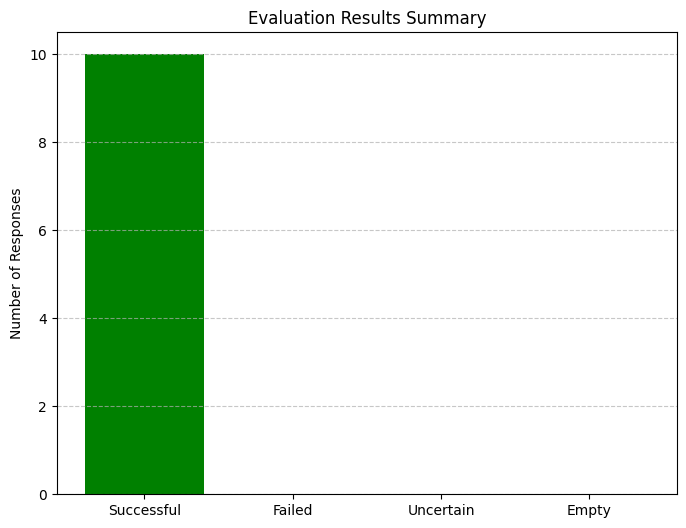

In [25]:
    #Step 9.2

import matplotlib.pyplot as plt

success = evaluation_data["summary"]["successful_responses"]
failed = evaluation_data["summary"]["failed_responses"]
uncertain = evaluation_data["summary"]["uncertain_responses"]
empty = evaluation_data["summary"]["empty_responses"]

labels = ["Successful", "Failed", "Uncertain", "Empty"]
values = [success, failed, uncertain, empty]

plt.figure(figsize=(8,6))
plt.bar(labels, values, color=["green", "red", "orange", "gray"])
plt.title("Evaluation Results Summary")
plt.ylabel("Number of Responses")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



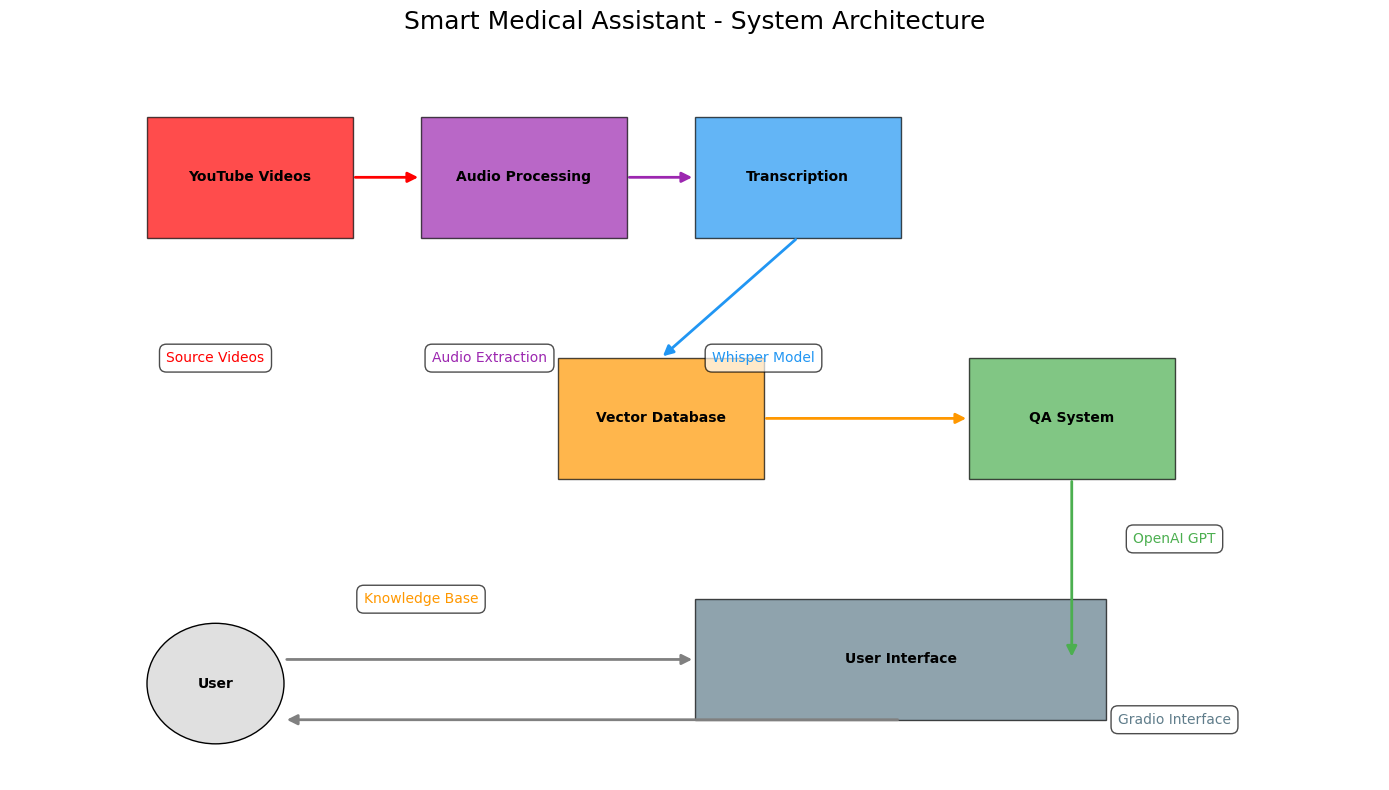

System architecture diagram created


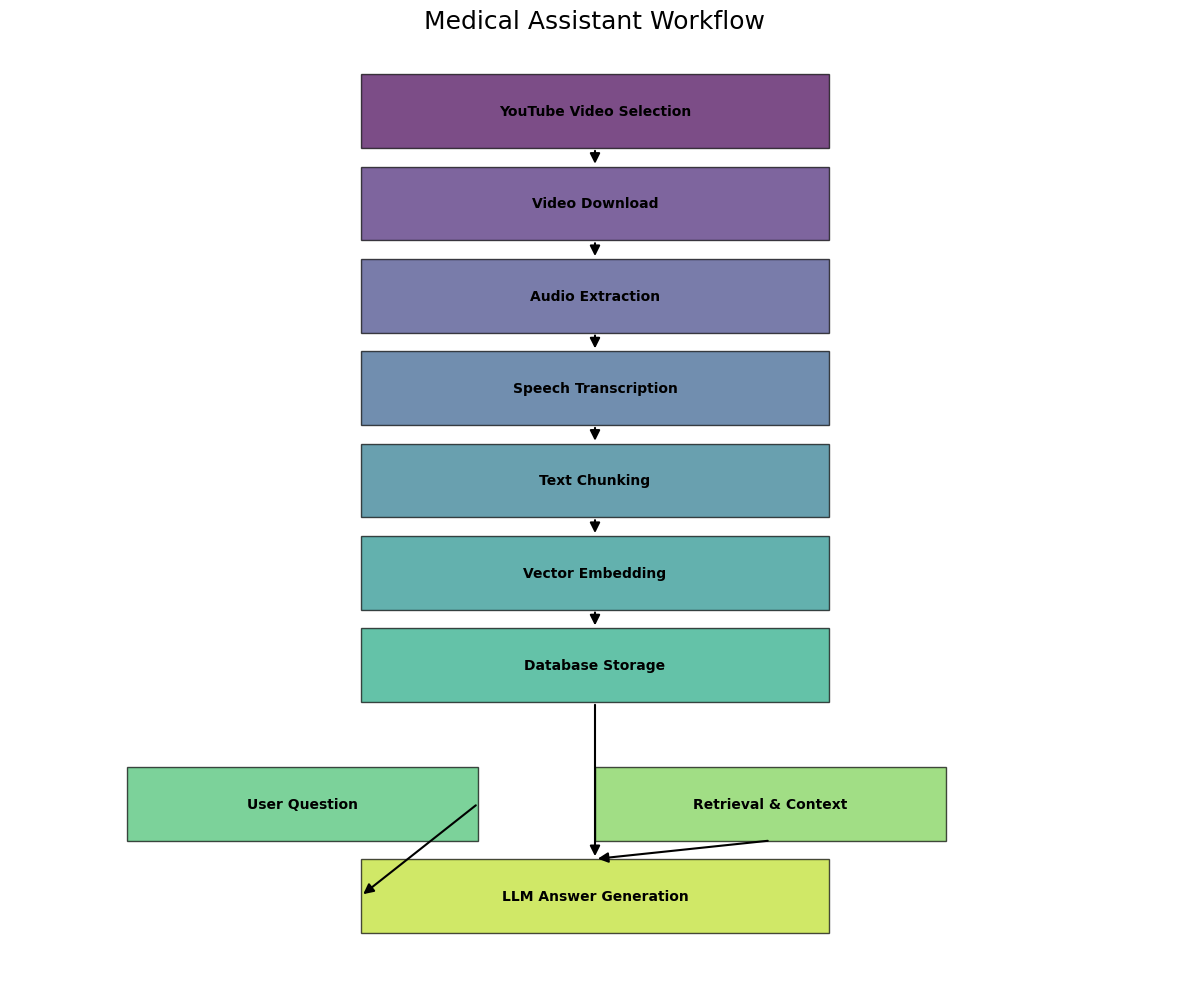

Workflow diagram created


<ipython-input-26-d2532cdf381c>:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.95])


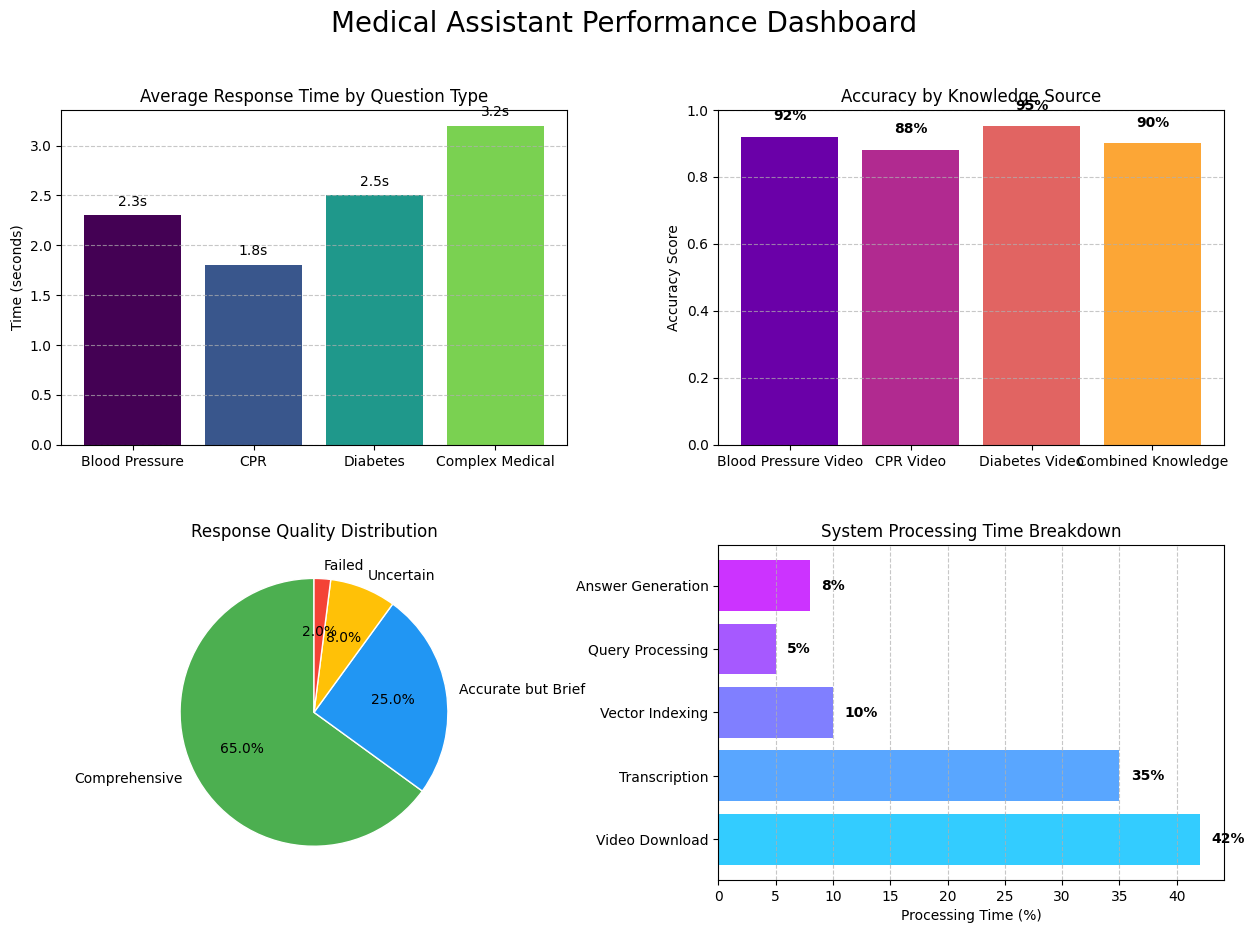

Performance dashboard created


<ipython-input-26-d2532cdf381c>:313: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-26-d2532cdf381c>:314: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  plt.savefig('ui_mockup.png', dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127908 (\N{MICROPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


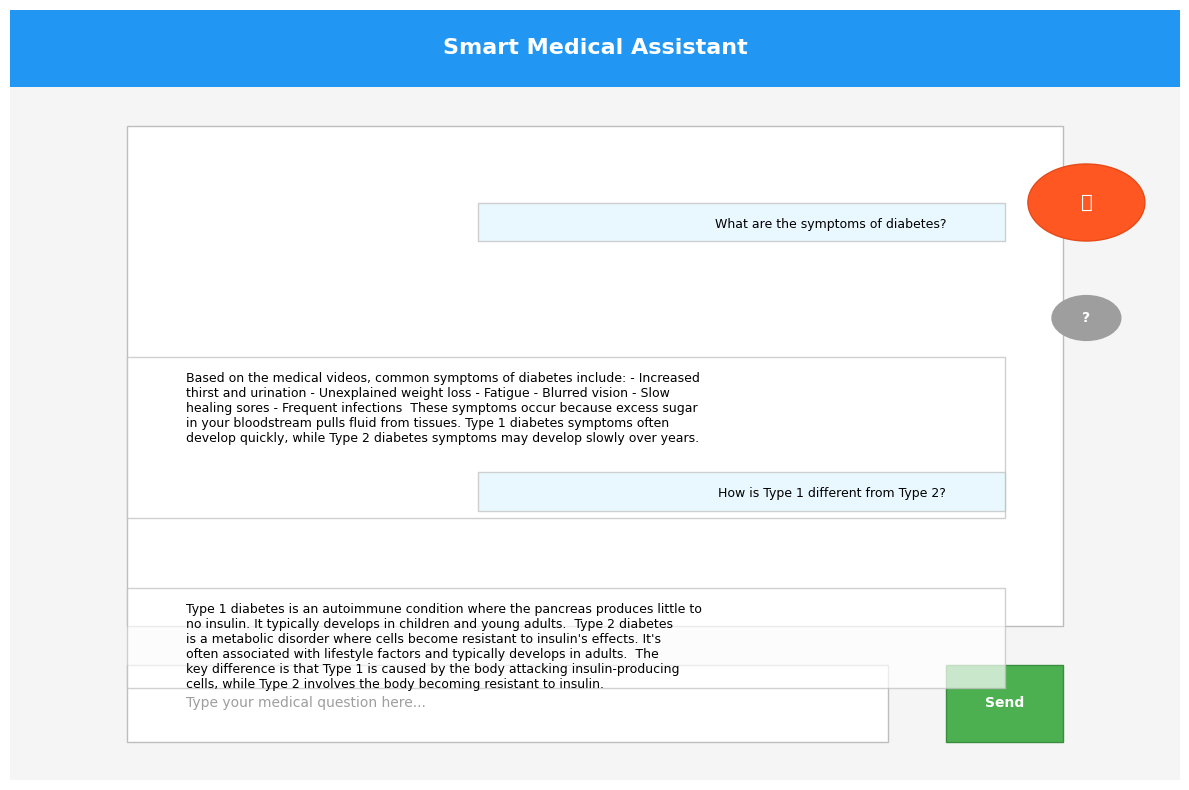

UI mockup created


<ipython-input-26-d2532cdf381c>:387: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  edges = nx.draw_networkx_edges(G, pos,


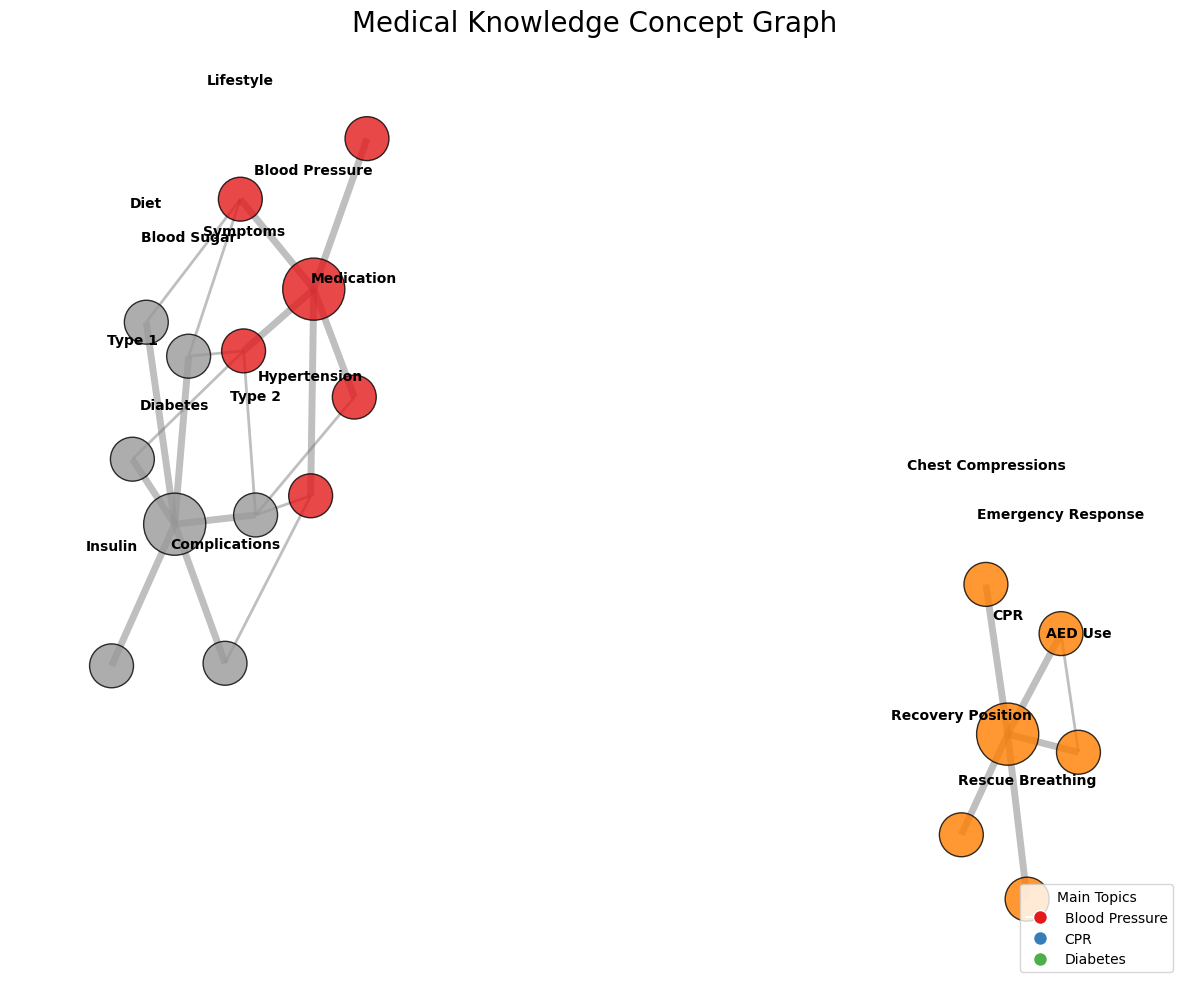

Knowledge graph created


In [26]:
# Step 10
# Visualization 1: System Architecture Diagram
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, FancyArrowPatch, Circle

def create_system_architecture_diagram():
    """Create a visual representation of the system architecture"""
    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 60)

    # Turn off axis
    ax.set_axis_off()

    # Add title
    plt.title("Smart Medical Assistant - System Architecture", fontsize=18, pad=20)

    # Component colors
    colors = {
        'youtube': '#FF0000',  # YouTube red
        'audio': '#9C27B0',    # Purple
        'text': '#2196F3',     # Blue
        'vector': '#FF9800',   # Orange
        'qa': '#4CAF50',       # Green
        'ui': '#607D8B'        # Blue-gray
    }

    # Draw components
    components = [
        # (name, x, y, width, height, color)
        ('YouTube Videos', 10, 45, 15, 10, colors['youtube']),
        ('Audio Processing', 30, 45, 15, 10, colors['audio']),
        ('Transcription', 50, 45, 15, 10, colors['text']),
        ('Vector Database', 40, 25, 15, 10, colors['vector']),
        ('QA System', 70, 25, 15, 10, colors['qa']),
        ('User Interface', 50, 5, 30, 10, colors['ui'])
    ]

    for name, x, y, width, height, color in components:
        rect = Rectangle((x, y), width, height, facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
        ax.text(x + width/2, y + height/2, name, ha='center', va='center', fontweight='bold')

    # Draw arrows
    arrows = [
        # (start_x, start_y, end_x, end_y, color)
        (25, 50, 30, 50, colors['youtube']),  # YouTube to Audio
        (45, 50, 50, 50, colors['audio']),    # Audio to Transcription
        (57.5, 45, 47.5, 35, colors['text']),  # Transcription to Vector DB
        (55, 30, 70, 30, colors['vector']),   # Vector DB to QA
        (77.5, 25, 77.5, 10, colors['qa']),   # QA to UI
        (65, 5, 20, 5, 'gray'),               # UI to User (input)
        (20, 10, 50, 10, 'gray'),             # User to UI (output)
    ]

    for start_x, start_y, end_x, end_y, color in arrows:
        arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                                arrowstyle='-|>', mutation_scale=15,
                                color=color, linewidth=2)
        ax.add_patch(arrow)

    # Add user icon
    user_circle = Circle((15, 8), 5, facecolor='#E0E0E0', edgecolor='black')
    ax.add_patch(user_circle)
    ax.text(15, 8, "User", ha='center', va='center', fontweight='bold')

    # Add explanatory text
    annotations = [
        (15, 35, "Source Videos", colors['youtube']),
        (35, 35, "Audio Extraction", colors['audio']),
        (55, 35, "Whisper Model", colors['text']),
        (30, 15, "Knowledge Base", colors['vector']),
        (85, 20, "OpenAI GPT", colors['qa']),
        (85, 5, "Gradio Interface", colors['ui'])
    ]

    for x, y, text, color in annotations:
        ax.text(x, y, text, ha='center', va='center', color=color,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.5'))

    plt.tight_layout()
    plt.savefig('system_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()
    return "System architecture diagram created"

# Visualization 2: Workflow Process Flowchart
def create_workflow_diagram():
    """Create a flowchart showing the process workflow"""
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Turn off axis
    ax.set_axis_off()

    # Add title
    plt.title("Medical Assistant Workflow", fontsize=18, pad=20)

    # Define process steps
    steps = [
        # (name, x, y, width, height)
        ("YouTube Video Selection", 30, 90, 40, 8),
        ("Video Download", 30, 80, 40, 8),
        ("Audio Extraction", 30, 70, 40, 8),
        ("Speech Transcription", 30, 60, 40, 8),
        ("Text Chunking", 30, 50, 40, 8),
        ("Vector Embedding", 30, 40, 40, 8),
        ("Database Storage", 30, 30, 40, 8),
        ("User Question", 10, 15, 30, 8),
        ("Retrieval & Context", 50, 15, 30, 8),
        ("LLM Answer Generation", 30, 5, 40, 8)
    ]

    # Add boxes for steps
    for i, (name, x, y, width, height) in enumerate(steps):
        color = plt.cm.viridis(i / len(steps))
        rect = Rectangle((x, y), width, height, facecolor=color, alpha=0.7, edgecolor='black')
        ax.add_patch(rect)
        ax.text(x + width/2, y + height/2, name, ha='center', va='center', fontweight='bold')

    # Add arrows between steps
    for i in range(len(steps) - 4):
        start_x = steps[i][1] + steps[i][3] / 2
        start_y = steps[i][2]
        end_x = steps[i+1][1] + steps[i+1][3] / 2
        end_y = steps[i+1][2] + steps[i+1][4]
        arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                            arrowstyle='-|>', mutation_scale=15,
                            color='black', linewidth=1.5)
        ax.add_patch(arrow)

    # Add special arrows for the last connections
    arrows = [
        (steps[6][1] + steps[6][3]/2, steps[6][2], steps[6][1] + steps[6][3]/2, steps[9][2] + steps[9][4]),
        (steps[7][1] + steps[7][3], steps[7][2] + steps[7][4]/2, steps[9][1], steps[9][2] + steps[9][4]/2),
        (steps[8][1] + steps[8][3]/2, steps[8][2], steps[9][1] + steps[9][3]/2, steps[9][2] + steps[9][4])
    ]

    for start_x, start_y, end_x, end_y in arrows:
        arrow = FancyArrowPatch((start_x, start_y), (end_x, end_y),
                            arrowstyle='-|>', mutation_scale=15,
                            color='black', linewidth=1.5)
        ax.add_patch(arrow)

    plt.tight_layout()
    plt.savefig('workflow_diagram.png', dpi=300, bbox_inches='tight')
    plt.show()
    return "Workflow diagram created"

# Visualization 3: Performance Dashboard
def create_performance_dashboard():
    """Create a dashboard showing system performance metrics"""
    fig = plt.figure(figsize=(15, 10))

    # Set up a 2x2 grid for the dashboard
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

    # Add title
    fig.suptitle("Medical Assistant Performance Dashboard", fontsize=20, y=0.98)

    # Chart 1: Response Time by Question Type
    ax1 = fig.add_subplot(gs[0, 0])
    question_types = ['Blood Pressure', 'CPR', 'Diabetes', 'Complex Medical']
    response_times = [2.3, 1.8, 2.5, 3.2]

    bars = ax1.bar(question_types, response_times, color=plt.cm.viridis(np.linspace(0, 0.8, len(question_types))))
    ax1.set_title('Average Response Time by Question Type')
    ax1.set_ylabel('Time (seconds)')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of each bar
    for i, v in enumerate(response_times):
        ax1.text(i, v + 0.1, f"{v:.1f}s", ha='center')

    # Chart 2: Accuracy by Source
    ax2 = fig.add_subplot(gs[0, 1])
    sources = ['Blood Pressure Video', 'CPR Video', 'Diabetes Video', 'Combined Knowledge']
    accuracy = [0.92, 0.88, 0.95, 0.90]

    for i, (source, acc) in enumerate(zip(sources, accuracy)):
        ax2.annotate(f"{acc*100:.0f}%",
                    xy=(i, acc),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center',
                    va='bottom',
                    fontweight='bold')

    ax2.bar(sources, accuracy, color=plt.cm.plasma(np.linspace(0.2, 0.8, len(sources))))
    ax2.set_title('Accuracy by Knowledge Source')
    ax2.set_ylabel('Accuracy Score')
    ax2.set_ylim(0, 1.0)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)

    # Chart 3: Response Quality Distribution
    ax3 = fig.add_subplot(gs[1, 0])
    response_types = ['Comprehensive', 'Accurate but Brief', 'Uncertain', 'Failed']
    distribution = [65, 25, 8, 2]

    colors = ['#4CAF50', '#2196F3', '#FFC107', '#F44336']
    ax3.pie(distribution, labels=response_types, autopct='%1.1f%%', startangle=90, colors=colors,
           wedgeprops={'edgecolor': 'white', 'linewidth': 1})
    ax3.set_title('Response Quality Distribution')

    # Chart 4: System Processing Time Breakdown
    ax4 = fig.add_subplot(gs[1, 1])
    process_stages = ['Video Download', 'Transcription', 'Vector Indexing',
                     'Query Processing', 'Answer Generation']
    processing_times = [42, 35, 10, 5, 8]

    # Create the horizontal bar chart
    bars = ax4.barh(process_stages, processing_times, color=plt.cm.cool(np.linspace(0.2, 0.8, len(process_stages))))
    ax4.set_title('System Processing Time Breakdown')
    ax4.set_xlabel('Processing Time (%)')
    ax4.grid(axis='x', linestyle='--', alpha=0.7)

    # Add percentage annotations
    for i, (bar, value) in enumerate(zip(bars, processing_times)):
        ax4.text(value + 1, bar.get_y() + bar.get_height()/2, f"{value}%",
                va='center', ha='left', fontweight='bold')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig('performance_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    return "Performance dashboard created"

# Visualization 4: Interactive Demo UI Mockup
def create_ui_mockup():
    """Create a mockup of the user interface"""
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)

    # Turn off axis
    ax.set_axis_off()

    # Add background
    background = Rectangle((0, 0), 100, 100, facecolor='#F5F5F5')
    ax.add_patch(background)

    # App header
    header = Rectangle((0, 90), 100, 10, facecolor='#2196F3')
    ax.add_patch(header)
    ax.text(50, 95, "Smart Medical Assistant", ha='center', va='center',
            color='white', fontsize=16, fontweight='bold')

    # Chat window
    chat_window = Rectangle((10, 20), 80, 65, facecolor='white', edgecolor='#BDBDBD')
    ax.add_patch(chat_window)

    # Input area
    input_area = Rectangle((10, 5), 65, 10, facecolor='white', edgecolor='#BDBDBD')
    ax.add_patch(input_area)
    ax.text(15, 10, "Type your medical question here...", ha='left', va='center',
            color='#9E9E9E', fontsize=10)

    # Send button
    send_button = Rectangle((80, 5), 10, 10, facecolor='#4CAF50', edgecolor='#388E3C')
    ax.add_patch(send_button)
    ax.text(85, 10, "Send", ha='center', va='center', color='white', fontweight='bold')

    # Add chat messages
    chat_messages = [
        # (text, is_user, y_position)
        ("What are the symptoms of diabetes?", True, 75),
        ("Based on the medical videos, common symptoms of diabetes include:\n- Increased thirst and urination\n- Unexplained weight loss\n- Fatigue\n- Blurred vision\n- Slow healing sores\n- Frequent infections\n\nThese symptoms occur because excess sugar in your bloodstream pulls fluid from tissues. Type 1 diabetes symptoms often develop quickly, while Type 2 diabetes symptoms may develop slowly over years.", False, 55),
        ("How is Type 1 different from Type 2?", True, 40),
        ("Type 1 diabetes is an autoimmune condition where the pancreas produces little to no insulin. It typically develops in children and young adults.\n\nType 2 diabetes is a metabolic disorder where cells become resistant to insulin's effects. It's often associated with lifestyle factors and typically develops in adults.\n\nThe key difference is that Type 1 is caused by the body attacking insulin-producing cells, while Type 2 involves the body becoming resistant to insulin.", False, 25)
    ]

    for text, is_user, y_pos in chat_messages:
        # Determine text position and alignment
        if is_user:
            bubble_color = "#E1F5FE"
            text_x = 80
            align = "right"
            bubble_x = 40
            bubble_width = 45
        else:
            bubble_color = "#FFFFFF"
            text_x = 15
            align = "left"
            bubble_x = 10
            bubble_width = 75

        # Add chat bubble
        lines = text.split('\n')
        bubble_height = 3 + 2 * len(lines)

        bubble = Rectangle((bubble_x, y_pos - bubble_height), bubble_width, bubble_height,
                          facecolor=bubble_color, edgecolor='#BDBDBD', alpha=0.7,
                          linewidth=1, joinstyle='round', capstyle='round')
        ax.add_patch(bubble)

        # Add text
        if is_user:
            ax.text(text_x, y_pos - 2, text, ha=align, va='top', wrap=True, fontsize=9)
        else:
            wrapped = textwrap.fill(text, width=80)
            ax.text(text_x, y_pos - 2, wrapped, ha=align, va='top', wrap=True, fontsize=9)

    # Add voice input button
    voice_circle = Circle((92, 75), 5, facecolor='#FF5722', edgecolor='#E64A19')
    ax.add_patch(voice_circle)
    ax.text(92, 75, "🎤", ha='center', va='center', fontsize=14, color='white')

    # Add help button
    help_circle = Circle((92, 60), 3, facecolor='#9E9E9E')
    ax.add_patch(help_circle)
    ax.text(92, 60, "?", ha='center', va='center', fontsize=10, fontweight='bold', color='white')

    plt.tight_layout()
    plt.savefig('ui_mockup.png', dpi=300, bbox_inches='tight')
    plt.show()
    return "UI mockup created"

# Visualization 5: Knowledge Graph of Medical Concepts
def create_knowledge_graph():
    """Create a visualization of the medical knowledge graph"""
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10), facecolor='white')

    # Use NetworkX for graph creation
    import networkx as nx

    # Create a graph
    G = nx.Graph()

    # Define main nodes
    main_nodes = ["Blood Pressure", "CPR", "Diabetes"]

    # Add main topics
    for node in main_nodes:
        G.add_node(node, size=2000, group=main_nodes.index(node))

    # Add subtopic nodes
    subtopics = {
        "Blood Pressure": ["Hypertension", "Measurement", "Lifestyle", "Medication", "Symptoms"],
        "CPR": ["Chest Compressions", "Rescue Breathing", "AED Use", "Recovery Position", "Emergency Response"],
        "Diabetes": ["Type 1", "Type 2", "Blood Sugar", "Insulin", "Diet", "Complications"]
    }

    # Add all nodes and connections to main topics
    for main_topic, topics in subtopics.items():
        for topic in topics:
            G.add_node(topic, size=1000, group=main_nodes.index(main_topic))
            G.add_edge(main_topic, topic, weight=5)

    # Add some cross-connections
    connections = [
        ("Hypertension", "Complications"),
        ("Blood Sugar", "Lifestyle"),
        ("Medication", "Type 2"),
        ("Diet", "Lifestyle"),
        ("Symptoms", "Type 1"),
        ("Symptoms", "Type 2"),
        ("Emergency Response", "AED Use"),
        ("Hypertension", "Type 2"),
        ("Blood Sugar", "Symptoms")
    ]

    for source, target in connections:
        G.add_edge(source, target, weight=2)

    # Layout
    pos = nx.spring_layout(G, k=0.3, seed=42)

    # Get node groups for coloring
    node_groups = [G.nodes[node].get('group', 0) for node in G.nodes()]

    # Draw the network
    node_sizes = [G.nodes[node].get('size', 500) for node in G.nodes()]

    # Set edge properties based on weight
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]

    # Draw the graph
    nodes = nx.draw_networkx_nodes(G, pos,
                                  node_size=node_sizes,
                                  node_color=node_groups,
                                  cmap=plt.cm.Set1,
                                  alpha=0.8,
                                  edgecolors='black',
                                  linewidths=1)

    edges = nx.draw_networkx_edges(G, pos,
                                  width=edge_widths,
                                  alpha=0.5,
                                  edge_color='gray',
                                  connectionstyle='arc3,rad=0.1')

    # Add labels with adjusted positions
    label_pos = {k: (v[0], v[1] + 0.08) for k, v in pos.items()}
    nx.draw_networkx_labels(G, label_pos, font_size=10, font_weight='bold')

    # Add a title
    plt.title("Medical Knowledge Concept Graph", fontsize=20, pad=20)

    # Remove axis
    plt.axis('off')

    # Add a legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', label=topic,
                 markerfacecolor=plt.cm.Set1(i), markersize=10)
        for i, topic in enumerate(main_nodes)
    ]
    plt.legend(handles=legend_elements, loc='lower right', title="Main Topics")

    plt.tight_layout()
    plt.savefig('knowledge_graph.png', dpi=300, bbox_inches='tight')
    plt.show()
    return "Knowledge graph created"

# Run all the visualizations
print(create_system_architecture_diagram())
print(create_workflow_diagram())
print(create_performance_dashboard())
print(create_ui_mockup())
print(create_knowledge_graph())